# Background

## Barren Plateaus
Barren plateaus are large regions of the cost functions parameter space where the variance of the gradient is almost 0; or, put another way, the cost function landscape is flat. This means that a variational circuit initialized in one of these areas will be untrainable any gradient based algorithm.

In "Cost-Function-Dependent Barren Plateaus in Shallow Quantum Neural Networks" Cerezo et al. demonstrate the idea that the barren plateau phenomenon can be avoided by using cost functions that only have information from part of the circuit. These *local* cost functions are more robust to noise, and have more well-behaved gradients with no plateaus for shallow circuits.

### Installs and Imports

In this notebook, we investigate the effect of barren plateaus in variational quantum algorithms, and how they can be mitigated using local cost functions.

In [1]:
!pip install git+https://github.com/XanaduAI/pennylane
!pip install autograd
!pip install git+https://github.com/XanaduAI/pennylane-qiskit

import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import template
from pennylane import broadcast
import pennylane.templates as templates
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

  Cloning https://github.com/XanaduAI/pennylane to /tmp/pip-req-build-ufgh2jnm
  Running command git clone -q https://github.com/XanaduAI/pennylane /tmp/pip-req-build-ufgh2jnm
  Created wheel for PennyLane: filename=PennyLane-0.10.0.dev0-cp36-none-any.whl size=247399 sha256=9fa3c83c926afb38b309f3e2d9c5b2dd4a785015ced75f8e998a88d47e93ff07
  Stored in directory: /tmp/pip-ephem-wheel-cache-3q9_2rqa/wheels/10/6a/b3/12f1d7b2fe4f4665d995fb31dd210e71787d47c315cacf9243
Successfully built PennyLane
  Cloning https://github.com/XanaduAI/pennylane-qiskit to /tmp/pip-req-build-6eogi927
  Running command git clone -q https://github.com/XanaduAI/pennylane-qiskit /tmp/pip-req-build-6eogi927
  Created wheel for PennyLane-qiskit: filename=PennyLane_qiskit-0.10.0.dev0-cp36-none-any.whl size=20881 sha256=d007c17e476f12b82b8ee2ac3887e733f9d16a94a66bd82fbf7fb07f73f26f57
  Stored in directory: /tmp/pip-ephem-wheel-cache-xz5n1yoi/wheels/1d/2d/a6/1115921caf7583f136b2fc9ac544e14b46c204088d3f8f124f
Successfully

# Visualizing the problem
To start, lets look at the toy problem of learning the identity gate across multiple qubits. This will help us visualize the problem and get a sense of what is happening in the cost landscape

First we define a number of wires we want to train on. The work by Cerezo et al. shows that circuits are trainible under certain ranges, so how many quibits we train on will effect our results.

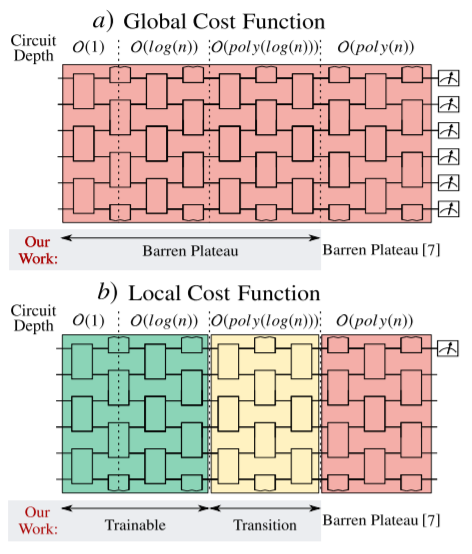


In [0]:
wires=6
dev = qml.device('default.qubit', wires=wires, shots=10000, analytic=False)

Next, we want to define our qnodes, containing our ansatz. For this simple example, an ansatz that works well is simply a rotation along X, and a rotation along Y, repeated across all the qubits.

We will also define our cost functions here. Since we are trying to learn the identity gate, a natural cost function is 

$ C = 1-(P_{|0>})$

We will apply this across all qubits for our global cost function, i.e.:

$ C_{G} = 1-(P_{|0>})$

and only on one qubit for our local cost function: 

$ C_{L} = 1-(P_{|0>,1}) $.

To implement this, we will define a separate qnode for the local cost function and the global cost function.

In [0]:
def global_cost_simple(rotations):
  for i in range(wires):
    qml.RX(rotations[0][i], wires=i)
  for i in range(wires):
    qml.RY(rotations[1][i],wires=i)
  return qml.probs(wires=range(wires))

def local_cost_simple(rotations):
  for i in range(wires):
    qml.RX(rotations[0][i], wires=i)
  for i in range(wires):
    qml.RY(rotations[1][i],wires=i)
  return qml.probs(wires=[0])

def cost_local(rotations):
  # result = circuit(rotations)
  # return sum(abs(result[i]) for i in range(wires))
  return 1-local_circuit(rotations)[0]


def cost_global(rotations):
  # result = circuit(rotations)
  # return sum(abs(result[i]) for i in range(wires))
  return 1-global_circuit(rotations)[0]

In [0]:
global_circuit = qml.QNode(global_cost_simple, dev)

local_circuit = qml.QNode(local_cost_simple, dev)

To analyze each of the circuits, we provide some random initial $\theta$'s for each rotation

In [0]:
RX=np.random.uniform(low=-np.pi, high = np.pi)
RY=np.random.uniform(low=-np.pi, high = np.pi)
rotations = [[RX for i in range(wires)], [RY for i in range(wires)]] 

And look at the results:

In [21]:
print("--- Global Circuit ---")
print(global_circuit.draw())
print("--- Local Circuit")
print(local_circuit.draw())

print("Global Cost: {: .7f}".format(cost_global(rotations)))
print("Local Cost: {: .7f}".format(cost_local(rotations)))


--- Global Circuit ---
 0: ──RX(3.0)──RY(0.0)──╭┤ Probs 
 1: ──RX(3.0)──RY(0.0)──├┤ Probs 
 2: ──RX(3.0)──RY(0.0)──├┤ Probs 
 3: ──RX(3.0)──RY(0.0)──├┤ Probs 
 4: ──RX(3.0)──RY(0.0)──├┤ Probs 
 5: ──RX(3.0)──RY(0.0)──╰┤ Probs 

--- Local Circuit
 0: ──RX(3.0)──RY(0.0)──┤ Probs 
 1: ──RX(3.0)──RY(0.0)──┤       
 2: ──RX(3.0)──RY(0.0)──┤       
 3: ──RX(3.0)──RY(0.0)──┤       
 4: ──RX(3.0)──RY(0.0)──┤       
 5: ──RX(3.0)──RY(0.0)──┤       

Global Cost:  1.0000000
Local Cost:  0.9949962


With this simple example, we can visualize the cost function, and see the barren plateau effect graphically.

In [0]:
%matplotlib inline
X = np.arange(-np.pi, np.pi, 1)
Y = np.arange(-np.pi, np.pi, 1)
X, Y = np.meshgrid(X, Y)

local_Z=[]
global_Z=[]
local_z=[]
global_z=[]

X = np.arange(-np.pi, np.pi, 0.25)
Y = np.arange(-np.pi, np.pi, 0.25)
X, Y = np.meshgrid(X, Y)

for x in X[0,:]:
  for y in Y[:,0]:
      rotations = [[x for i in range(wires)], [y for i in range(wires)]]
      local_z.append(cost_local(rotations))
      global_z.append(cost_global(rotations))
  local_Z.append(local_z)
  global_Z.append(global_z)
  local_z=[]
  global_z=[]

local_Z=np.asarray(local_Z)
global_Z=np.asarray(global_Z)

Firstly, we look at the global cost function. When plotting the cost function across 6 qubits, much of the cost landscape is flat, and difficult to train (even with a circuit depth of only 2!). This effect will worsen as the number of qubits increases.

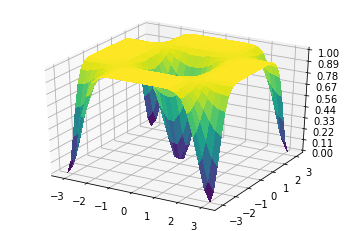

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X,Y, global_Z, cmap='viridis', linewidth=0, antialiased=False)
ax.set_zlim(0, 1)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
plt.show()

However, when we change to the local cost function, the cost lanscape becomes much more trainable.

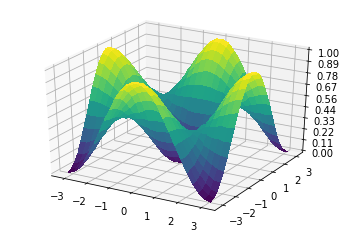

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X,Y, local_Z, cmap='viridis', linewidth=0, antialiased=False)
ax.set_zlim(0, 1)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
plt.show()

Those are some nice pictures, but how do they refect actual trainability? Lets try training both the local, and global cost functions. Because we have a visualization of the total cost landscape, lets pick a point to exaggerate the problem. The worst point in the landscape is $(\pi,0)$, so lets use that. 

In [11]:
rotations = [[3 for i in range(wires)], [0 for i in range(wires)]]
opt = qml.GradientDescentOptimizer(stepsize=0.2)
steps = 100
params_global = rotations
for i in range(steps):
    # update the circuit parameters
    params_global = opt.step(cost_global, params_global)

    if (i + 1) % 1 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost_global(params_global)))
    if cost_global(params_global)<0.1:
      break
print(global_circuit.draw())

Cost after step     1:  1.0000000
Cost after step     2:  1.0000000
Cost after step     3:  1.0000000
Cost after step     4:  1.0000000
Cost after step     5:  1.0000000
Cost after step     6:  1.0000000
Cost after step     7:  1.0000000
Cost after step     8:  1.0000000
Cost after step     9:  1.0000000
Cost after step    10:  1.0000000
Cost after step    11:  1.0000000
Cost after step    12:  1.0000000
Cost after step    13:  1.0000000
Cost after step    14:  1.0000000
Cost after step    15:  1.0000000
Cost after step    16:  1.0000000
Cost after step    17:  1.0000000
Cost after step    18:  1.0000000
Cost after step    19:  1.0000000
Cost after step    20:  1.0000000
Cost after step    21:  1.0000000
Cost after step    22:  1.0000000
Cost after step    23:  1.0000000
Cost after step    24:  1.0000000
Cost after step    25:  1.0000000
Cost after step    26:  1.0000000
Cost after step    27:  1.0000000
Cost after step    28:  1.0000000
Cost after step    29:  1.0000000
Cost after ste

After 100 steps, the cost function is still exactly 1. Clearly we are in an untrainable area. Now, lets limit the ourselves to the local cost function and see how it performs.

In [12]:
rotations = [[3. for i in range(wires)], [0 for i in range(wires)]] 
opt = qml.GradientDescentOptimizer(stepsize=0.2)
steps = 100
params_local = rotations
for i in range(steps):
    # update the circuit parameters
    params_local = opt.step(cost_local, params_local)

    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost_local(params_local)))
    if cost_local(params_local)<0.05:
      break
print(local_circuit.draw())

Cost after step     5:  0.9855000
Cost after step    10:  0.9677000
Cost after step    15:  0.9167000
Cost after step    20:  0.8096000
Cost after step    25:  0.6119000
Cost after step    30:  0.3674000
Cost after step    35:  0.1784000
Cost after step    40:  0.0727000
 0: ──RX(0.395)──RY(0.001)──┤ Probs 
 1: ──RX(3.0)────RY(0.0)────┤       
 2: ──RX(3.0)────RY(0.0)────┤       
 3: ──RX(3.0)────RY(0.0)────┤       
 4: ──RX(3.0)────RY(0.0)────┤       
 5: ──RX(3.0)────RY(0.0)────┤       



It trained! And much faster than the global case. However, we know our local cost function is faithful to the global one, but just how much have we trained it?

In [13]:
cost_global(params_local)

1.0

Interestingly, the global cost function is still 1. If we trained the local cost function, why hasnt the global cost function changed?

The answer is that we have trained the global cost a *little bit*, but not enough to see a change with only 10000 shots. To see the effect, we'll need to increase the number of shots to an unreasonable amount. Instead the making the backend analytic gives us the exact representation.

In [14]:
dev.analytic = True
global_circuit = qml.QNode(global_cost_simple, dev)
print("Current cost: " +str(cost_global(params_local)) + 
      ". Initial cost: "+str(cost_global([[3. for i in range(wires)], [0 for i in range(wires)]])) +
      ". Difference: "+str(cost_global([[3. for i in range(wires)], [0 for i in range(wires)]])-cost_global(params_local)))

Current cost: 0.999999999996984. Initial cost: 0.9999999999999843. Difference: 3.0003777240494856e-12


Our circuit has definitely been trained, but not a useful amount. If we attempt to use this circuit, we are no better than random chance. Furthermore, if we now attempt to train the global cost function, we are still firmly in the plateau region. In order to fully train the global circuit, we will need to increase the locality gradually as we train.

In [0]:
def tunable_cost_simple(rotations):
  for i in range(wires):
    qml.RX(rotations[0][i], wires=i)
  for i in range(wires):
    qml.RY(rotations[1][i],wires=i)
  return qml.probs(range(locality))

def cost_tunable(rotations):
  # result = circuit(rotations)
  # return sum(abs(result[i]) for i in range(wires))
  return 1-tunable_circuit(rotations)[0]

In [23]:
tunable_circuit = qml.QNode(tunable_cost_simple, dev)
locality=2
params_tunable=params_local
print(cost_tunable(params_tunable))
print(tunable_circuit.draw())

0.9951887967458982
 0: ──RX(0.395)──RY(0.001)──╭┤ Probs 
 1: ──RX(3.0)────RY(0.0)────╰┤ Probs 
 2: ──RX(3.0)────RY(0.0)─────┤       
 3: ──RX(3.0)────RY(0.0)─────┤       
 4: ──RX(3.0)────RY(0.0)─────┤       
 5: ──RX(3.0)────RY(0.0)─────┤       



In [24]:
locality=2
opt = qml.GradientDescentOptimizer(stepsize=0.1)
steps = 600
for i in range(steps):
    # update the circuit parameters
    params_tunable = opt.step(cost_tunable, params_tunable)

    runCost=cost_tunable(params_tunable)
    if (i + 1) % 10 == 0:
      print("Cost after step {:5d}: {: .7f}".format(i + 1, runCost) + ". Locality: "+str(locality))

    if (runCost<0.1 and locality<wires):
      print("---Switching Locality---")
      locality+=1
      continue
    elif (runCost<0.1 and locality>=wires):
      break
print(tunable_circuit.draw())

Cost after step    10:  0.9877802. Locality: 2
Cost after step    20:  0.9692858. Locality: 2
Cost after step    30:  0.9247601. Locality: 2
Cost after step    40:  0.8263905. Locality: 2
Cost after step    50:  0.6457019. Locality: 2
Cost after step    60:  0.4065622. Locality: 2
Cost after step    70:  0.2015231. Locality: 2
---Switching Locality---
Cost after step    80:  0.9950372. Locality: 3
Cost after step    90:  0.9880173. Locality: 3
Cost after step   100:  0.9713100. Locality: 3
Cost after step   110:  0.9326605. Locality: 3
Cost after step   120:  0.8489411. Locality: 3
Cost after step   130:  0.6916686. Locality: 3
Cost after step   140:  0.4657219. Locality: 3
Cost after step   150:  0.2470651. Locality: 3
Cost after step   160:  0.1075053. Locality: 3
---Switching Locality---
Cost after step   170:  0.9900681. Locality: 4
Cost after step   180:  0.9762950. Locality: 4
Cost after step   190:  0.9443266. Locality: 4
Cost after step   200:  0.8739923. Locality: 4
Cost after

Now the circuit can be trained, even though we started from a place where the the global function has a barren plateau. The significance of this is that we can now train from every starting location in this example.